In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

📋 미션 1: 교육 프로그램의 학습 효과 분석 보고서

In [2]:
# 데이터 준비
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


In [20]:
### 1. 기본 통계량 비교

control = education_data[education_data['group'] == 'Control']['math_score']
smartlearn = education_data[education_data['group'] == 'SmartLearn']['math_score']


# 평균
control_mean = np.mean(control)
smartlearn_mean = np.mean(smartlearn)

# SE = std / sqrt(n) -> 작을 수록 불확실성이 낮다
control_se = np.std(control, ddof=1) / np.sqrt(len(control))
smartlearn_se = np.std(smartlearn, ddof=1) / np.sqrt(len(smartlearn))

diff_mean = smartlearn_mean - control_mean
diff_se = np.sqrt(control_se**2 + smartlearn_se**2)

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")

print(f"\n✅ SmartLearn 수학 점수의 평균이 {diff_mean:.2f}점 더 높아 에듀테크 플랫폼의 성적 향상 효과 확인이 되었습니다.")

대조군 수학 점수: 64.93 ± 0.79
SmartLearn 수학 점수: 70.47 ± 0.92

✅ SmartLearn 수학 점수의 평균이 5.54점 더 높아 에듀테크 플랫폼의 성적 향상 효과 확인이 되었습니다.


In [21]:
# 2. 통계적 유의성 검증 : 독립표본 t-검정

t_stat, p_value = stats.ttest_ind(smartlearn, control, equal_var=False) # 등분산 가정 X

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("\n✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("\n❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")

t-통계량: 4.565
p-value: 0.0000

✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


In [22]:
# 3. 효과 크기 평가
control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = (smartlearn_mean - control_mean) / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")

Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


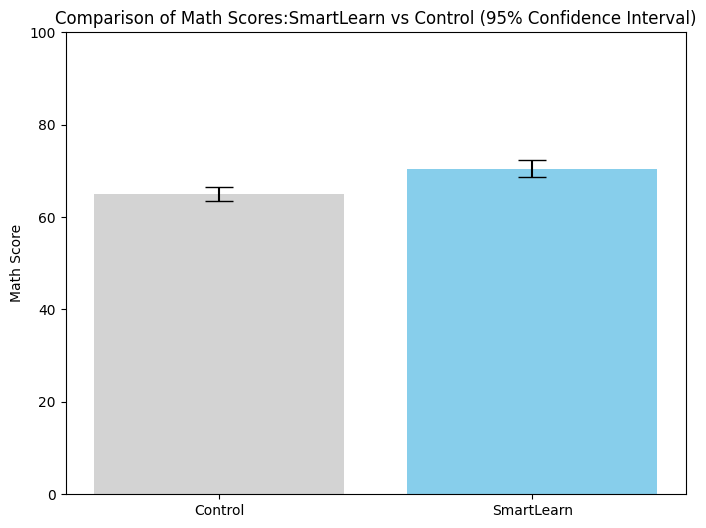

In [26]:
# 4. 결과 시각화
# 신뢰구간(CI, Confidence Interval) 95%: 진짜 평균이 이 범위 안에 있을 확률이 95%다!
plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(groups, means, yerr = errors, capsize=10, color =['lightgray', 'skyblue'])
plt.ylabel('Math Score')
plt.title('Comparison of Math Scores:SmartLearn vs Control (95% Confidence Interval)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.show()


📋 p-해킹 방지 방안
1. 사전 등록: 연구 계획을 Open Science Framework(OSF)에 등록하여 분석 계획을 투명하게 공개.
2. 다중비교 보정: Bonferroni 또는 FDR 방법을 적용하여 다중 검정으로 인한 오류를 최소화.
3. p-해킹을 방지하기 위한 추가 방안을 제안하세요 (예: 효과 크기 사전 설정, 독립적 검증 등)
 -  p < 0.05m  의미 있는 효과 크기(Cohen’s d > 0.5 등)를 사전에 기준 설정
 -  동일한 데이터를 다른 분석가에게 제공해 동일한 결론이 나오는지 검증
 - 베이즈 인수를 구해 추가 검증

In [29]:
# 6. 베이즈 인수 계산
# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")


베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


In [36]:
# 7. 경영진 보고서 작성

# 핵심 결과
print("📋 경영진 보고서: SmartLearn 프로그램 효과 검증")
print("="*50)
print("🎯 핵심 결과")
print(f"• 대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"• SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")
print(f"• 점수 향상: {diff_mean:.2f}점 (약 {(diff_mean/control_mean)*100:.2f}%)")
print(f"• 효과크기 (Cohen's d): {cohens_d:.3f}")
print(f"• p-value: {p_value:.4f}")
print(f"• 베이즈 인수 (BF₁₀): {bf_10:.2f}")

# 상용화 여부 판단 조건
print("\n🧪 상용화 판단 결과")
if (p_value < 0.05) and (cohens_d > 0.5) and (bf_10 > 3):
    print("✅ SmartLearn은 통계적 유의성과 교육적으로 의미 있는 효과를 보이며, 상용화에 적합한 수준입니다.")
elif (p_value < 0.05) and (cohens_d > 0.2):
    print("⚠️ 통계적으로 유의하나, 효과 크기가 작습니다. 추가 개선 후 상용화를 고려하세요.")
else:
    print("❌ 현재 분석으로는 SmartLearn의 효과가 뚜렷하지 않으며, 상용화 타당성이 낮습니다.")

# 투자자 제안
print("\n💰 투자자 제안")
print("• SmartLearn은 통계적으로 유의미한 교육 효과를 입증한 국내최초 AI 학습 플랫폼")
print("• 전국 공교육 도입과 SaaS 기반 글로벌 확장을 목표로 하고 있으며, 제품 고도화 및 시장 확대를 위한 전략적 투자 필요")

# 교육부 제안
print("\n🏫 교육부 제안")
print("• SmartLearn은 성과가 검증된 AI 기반 학습 도구로, 교육부 정책(맞춤형 학습, 디지털 교과서) 추진에 효과적")
print("•농어촌/도시 간 격차 해소, 데이터 기반 성취도 분석, 학습자 맞춤형 콘텐츠를 제공할 수 있어 전국 공교육에 시범 도입을 제안")

# 마케팅 전략
print("\n📣 마케팅 전략")
print("• 신뢰도 확보 : 교육효과의 통계적 신뢰성 강조 및 전후 비교 사례 강조")
print("• 케이스 광고 : 학부모 설득을 위한 실사용자 인터뷰 스토리 발굴해 광고 및 홍보 포인트로 활용")
print("• 시장 선점 : 경쟁사(MathGenius) 출시 전, 효과 기반 비교 광고와 조기 도입 혜택을 통해 시장 선점을 추진")

# 리스크 및 제한사항
print("\n⚠️ 리스크 및 제한사항")
print("• 통제변수(사전 성적, 지역, 성별 등)를 반영하지 않아 결과에 편향 가능성 있음.")
print("• 샘플 수는 적절하나 실제 상용화 대상과 인구 특성(예: 시골 지역, 고학년 등)이 다를 수 있음.")
print("• 단기간(6개월) 효과만 분석되었으며, 장기 지속성은 검증되지 않음.")
print("• 분석자의 주관이 개입되지 않도록 블라인드 검증, 재현 분석 필요.")

📋 경영진 보고서: SmartLearn 프로그램 효과 검증
🎯 핵심 결과
• 대조군 수학 점수: 64.93 ± 0.79
• SmartLearn 수학 점수: 70.47 ± 0.92
• 점수 향상: 5.54점 (약 8.53%)
• 효과크기 (Cohen's d): 0.527
• p-value: 0.0000
• 베이즈 인수 (BF₁₀): 1934.97

🧪 상용화 판단 결과
✅ SmartLearn은 통계적 유의성과 교육적으로 의미 있는 효과를 보이며, 상용화에 적합한 수준입니다.

💰 투자자 제안
• SmartLearn은 통계적으로 유의미한 교육 효과를 입증한 국내최초 AI 학습 플랫폼
• 전국 공교육 도입과 SaaS 기반 글로벌 확장을 목표로 하고 있으며, 제품 고도화 및 시장 확대를 위한 전략적 투자 필요

🏫 교육부 제안
• SmartLearn은 성과가 검증된 AI 기반 학습 도구로, 교육부 정책(맞춤형 학습, 디지털 교과서) 추진에 효과적
•농어촌/도시 간 격차 해소, 데이터 기반 성취도 분석, 학습자 맞춤형 콘텐츠를 제공할 수 있어 전국 공교육에 시범 도입을 제안

📣 마케팅 전략
• 신뢰도 확보 : 교육효과의 통계적 신뢰성 강조 및 전후 비교 사례 강조
• 케이스 광고 : 학부모 설득을 위한 실사용자 인터뷰 스토리 발굴해 광고 및 홍보 포인트로 활용
• 시장 선점 : 경쟁사(MathGenius) 출시 전, 효과 기반 비교 광고와 조기 도입 혜택을 통해 시장 선점을 추진

⚠️ 리스크 및 제한사항
• 통제변수(사전 성적, 지역, 성별 등)를 반영하지 않아 결과에 편향 가능성 있음.
• 샘플 수는 적절하나 실제 상용화 대상과 인구 특성(예: 시골 지역, 고학년 등)이 다를 수 있음.
• 단기간(6개월) 효과만 분석되었으며, 장기 지속성은 검증되지 않음.
• 분석자의 주관이 개입되지 않도록 블라인드 검증, 재현 분석 필요.


📋 미션 2: 마케팅 캠페인 효과 분석 보고서

In [37]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))

📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


In [73]:
data_marketing

,ad_exposure,age,income,purchase_amount
0,1,25,48691.249679,153.514575
1,1,40,32623.641202,181.909905
2,0,32,102879.065306,169.506984
3,0,59,60285.897464,114.745655
4,0,23,65248.882219,94.045179
...,...,...,...,...
995,0,28,47861.766550,106.924893
996,1,24,51482.808460,155.225127
997,0,22,73511.504252,137.050310
998,1,41,65728.382953,153.370644


In [39]:
data_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ad_exposure      1000 non-null   int64  
 1   age              1000 non-null   int64  
 2   income           1000 non-null   float64
 3   purchase_amount  1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


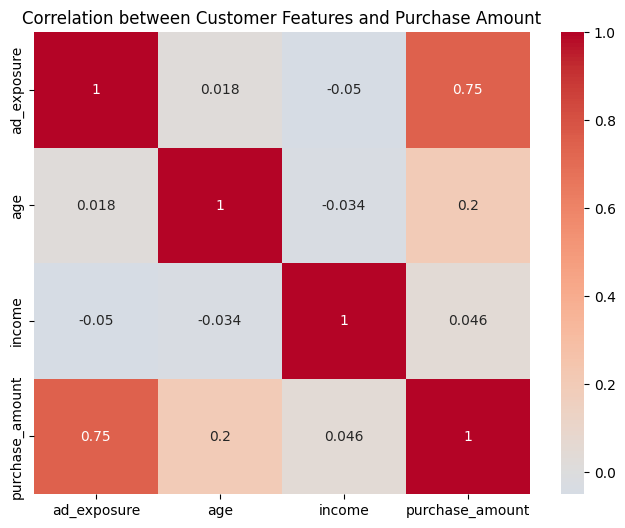

In [41]:
# 1. 상관관계 탐색

correlation_matrix = data_marketing.corr(numeric_only=True)

print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Customer Features and Purchase Amount')
plt.show()



In [47]:
# 2. 단순 비교와 한계
exposed_mean = data_marketing.loc[data_marketing['ad_exposure'] == 1, 'purchase_amount'].mean()
non_exposed_mean = data_marketing.loc[data_marketing['ad_exposure'] == 0, 'purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")


광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


In [48]:
# 3. 다중회귀분석

# 모델 학습
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
model.fit(X, y)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")

📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


In [51]:
# 4. 모델 신뢰도 평가

cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2') # r2로 평가하겠다는 의미
print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")


5-폴드 교차검증 R²: 0.597 ± 0.023
모델 설명력: 59.7% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


In [63]:
# 5. 인과관계 해석

ad_effect = model.coef_[0]
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000  # 광고비 2억원
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")

📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


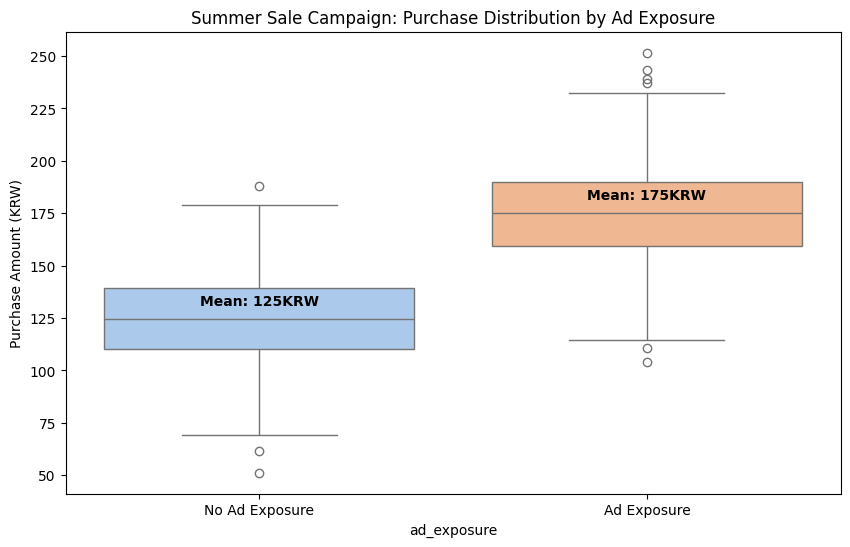

✅ 광고 노출 그룹의 구매액 박스가 비노출 그룹보다 더 위로 치우쳐 있음
✅ 두 그룹간 평균구매 금액의 차이가 시각적으로 뚜렷이 확인됨


In [72]:
# 6. 결과 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing, palette='pastel')
plt.xticks([0, 1], ['No Ad Exposure', 'Ad Exposure'])
plt.ylabel('Purchase Amount (KRW)')
plt.title('Summer Sale Campaign: Purchase Distribution by Ad Exposure')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'Mean: {mean_val:.0f}KRW', ha='center', va='bottom', fontweight='bold')
plt.show()


print("✅ 광고 노출 그룹의 구매액 박스가 비노출 그룹보다 더 위로 치우쳐 있음")
print("✅ 두 그룹간 평균구매 금액의 차이가 시각적으로 뚜렷이 확인됨")

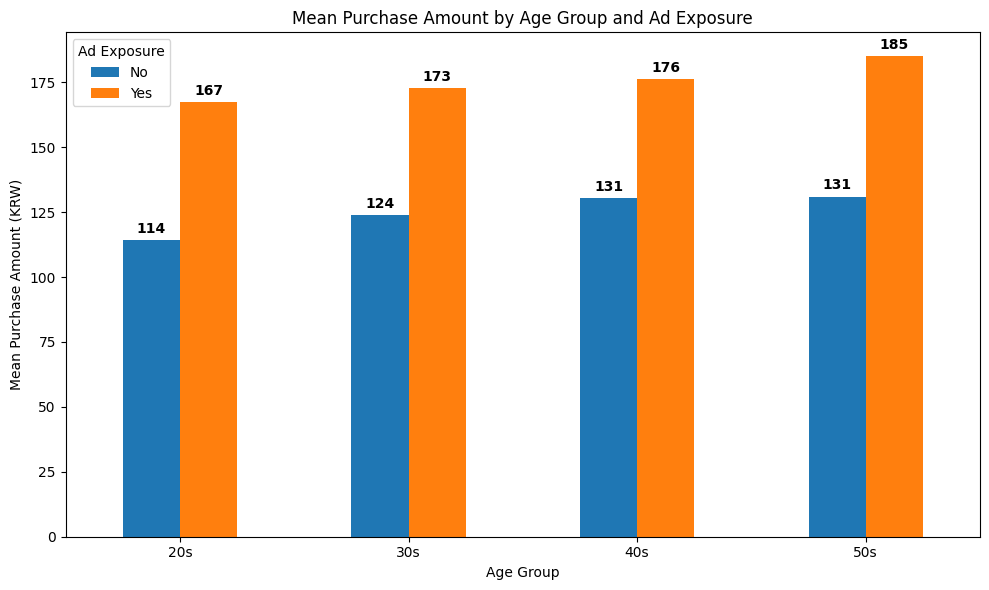

In [79]:
# 연령 그룹화
data_marketing['age_group'] = pd.cut(data_marketing['age'], bins=[20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s'])

ad_age_effect = data_marketing.groupby(['age_group', 'ad_exposure'])['purchase_amount'].mean().unstack()

ax = ad_age_effect.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Purchase Amount by Age Group and Ad Exposure')
plt.ylabel('Mean Purchase Amount (KRW)')
plt.xlabel('Age Group')
plt.xticks(rotation=0)
plt.legend(title='Ad Exposure', labels=['No', 'Yes'])

# 수치 라벨 추가
for container_age in ax.containers:
    ax.bar_label(container_age, fmt='%.0f', label_type='edge', padding=3, fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

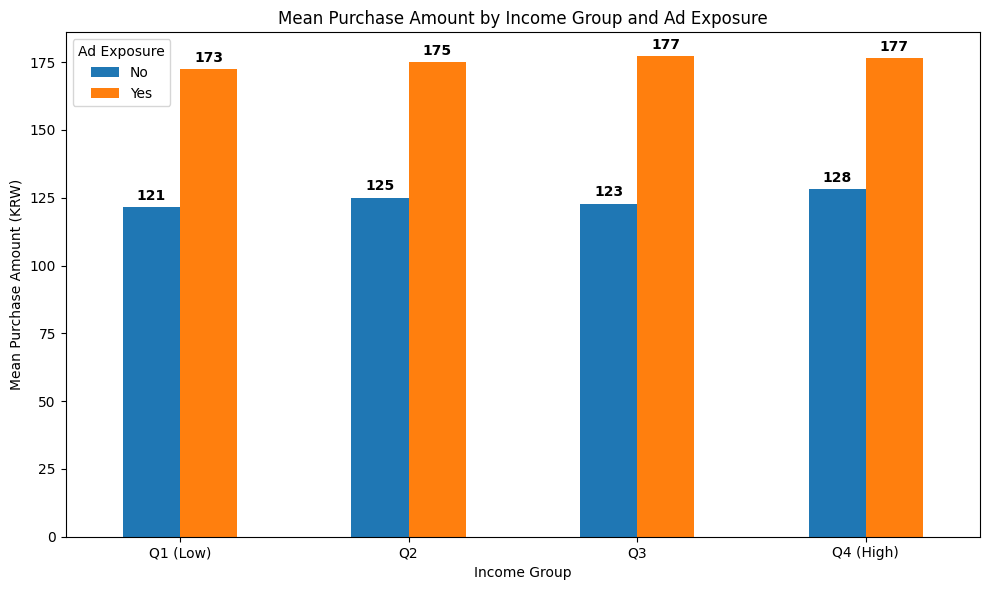

In [107]:
# 평균 구매 금액 테이블 생성
ad_income_effect = data_marketing.groupby(['income_group', 'ad_exposure'])['purchase_amount'].mean().unstack()

# 그래프 스타일
ax = ad_income_effect.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Purchase Amount by Income Group and Ad Exposure')
plt.ylabel('Mean Purchase Amount (KRW)')
plt.xlabel('Income Group')
plt.xticks(rotation=0)
plt.legend(title='Ad Exposure', labels=['No', 'Yes'])

# 수치 라벨 추가
for container_income in ax.containers:
    ax.bar_label(container_income, fmt='%.0f', label_type='edge', padding=3, fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

In [108]:
age_table = data_marketing.groupby(['age_group', 'ad_exposure'])['purchase_amount'].mean().unstack()
# 차이 계산 열 추가
age_table['Difference'] = age_table[1] - age_table[0]
age_table.columns = ['No Ad', 'Ad', 'Difference']
age_table = age_table.round(2)

income_table = data_marketing.groupby(['income_group', 'ad_exposure'])['purchase_amount'].mean().unstack()
income_table['Difference'] = income_table[1] - income_table[0]
income_table.columns = ['No Ad', 'Ad', 'Difference']
income_table = income_table.round(2)


print("📊 연령대별 광고 노출 효과")
print(age_table.round(2))
print("\n📊 소득별 광고 노출 효과")
print(income_table.round(2))

# 가장 효과 큰 소득 그룹 추출
age_table_sort = age_table.sort_values('Difference',ascending=False)
income_table_sort = income_table.sort_values('Difference',ascending=False)

print(f"\n✅ 연령대별 광고 효과가 가장 컸던 그룹: {age_table_sort.index[0]} (평균 {age_table_sort.iloc[0]['Difference']:.2f}원 증가)")
print(f"✅ 소득별 광고 효과가 가장 컸던 그룹: {income_table_sort.index[0]} (평균 {income_table_sort.iloc[0]['Difference']:.2f}원 증가)")



📊 연령대별 광고 노출 효과
            No Ad      Ad  Difference
age_group                            
20s        114.37  167.35       52.98
30s        123.77  172.72       48.96
40s        130.52  176.25       45.73
50s        130.96  184.97       54.02

📊 소득별 광고 노출 효과
               No Ad      Ad  Difference
income_group                            
Q1 (Low)      121.45  172.54       51.08
Q2            125.10  175.12       50.02
Q3            122.86  177.15       54.29
Q4 (High)     128.08  176.53       48.45

✅ 연령대별 광고 효과가 가장 컸던 그룹: 50s (평균 54.02원 증가)
✅ 소득별 광고 효과가 가장 컸던 그룹: Q3 (평균 54.29원 증가)


In [109]:
# 7. 경영진 보고서 작성

print("📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석")
print("="*60)
print("🎯 핵심 성과 지표")
print(f"• 광고 노출 그룹 평균 구매 금액: {exposed_mean:.2f}원")
print(f"• 광고 비노출 그룹 평균 구매 금액: {non_exposed_mean:.2f}원")
print(f"• 순수 광고 효과 (통제 후): {ad_effect:.2f}원")
print(f"• 모델 설명력 (R²): {cv_scores.mean():.3f} ± {cv_scores.std():.3f} ({cv_scores.mean()*100:.1f}% 설명력)")
print(f"• 광고 ROI: {roi:.1f}%")

print("\n📈 추가 분석 인사이트")
print(f"• 연령대별 광고 효과가 가장 컸던 그룹: {age_table_sort.index[0]} (평균 {age_table_sort.iloc[0]['Difference']:.2f}원 증가)")
print(f"• 소득 분위수별 광고 효과가 가장 컸던 그룹: {income_table_sort.index[0]} (평균 {income_table_sort.iloc[0]['Difference']:.2f}원 증가)")
print("• 고연령·중소득층(Q3)에서 광고 반응이 더 강하게 나타남 → 타겟팅 근거 확보")

print("\n💡 전략적 권장사항")
print(f"• 광고를 통해 개인당 구매금액은 상승하였으나, ROI는 {roi:.1f}%로 손실")
print("• 광고 단가 조정, 광고 고효율 고객층 및 채널 검정을 통한 리타겟팅 및 광고 예산 분배 개선 필요")
print("• 9월 추석 캠페인 전 연령대 및 소득별 광고 효율에 대해 추가 검증 후 리타케팅 통해 ROI 개선 필요")
print("• 고효율 고객층에게 리타겟팅 광고, 쿠폰 연계 제공")
print("• 광고 예산의 일부를 광고 미노출 그룹 확보에 재분배하여 추가 수익 극대화")
print("• 모델 기반 고객 스코어링 활용해 자동화된 타겟 선정")

print("\n⚠️ 리스크 요소")
print("• 관찰 데이터 기반 분석으로 인과관계 해석에 한계 존재 (선호도/브랜드 인지도 등 통제 불가)")
print("• 광고의 장기적 효과(충성도, 브랜드 가치 향상 등)는 미포함")

print("\n📅 향후 액션 아이템")
print("• 다음 캠페인에서는 랜덤화된 A/B 테스트 설계 도입")
print("• 미노출 고객 타겟팅을 위한 추가 데이터 수집 및 추천 시스템 고도화")
print("• 광고 채널별 효과 비교 및 멀티터치 어트리뷰션 분석 추진")
print("• 연령·소득 외에도 관심사/구매패턴 기반 세분화 전략 추가 도입")

📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
🎯 핵심 성과 지표
• 광고 노출 그룹 평균 구매 금액: 175.32원
• 광고 비노출 그룹 평균 구매 금액: 124.60원
• 순수 광고 효과 (통제 후): 50.79원
• 모델 설명력 (R²): 0.597 ± 0.023 (59.7% 설명력)
• 광고 ROI: -100.0%

📈 추가 분석 인사이트
• 연령대별 광고 효과가 가장 컸던 그룹: 50s (평균 54.02원 증가)
• 소득 분위수별 광고 효과가 가장 컸던 그룹: Q3 (평균 54.29원 증가)
• 고연령·중소득층(Q3)에서 광고 반응이 더 강하게 나타남 → 타겟팅 근거 확보

💡 전략적 권장사항
• 광고를 통해 개인당 구매금액은 상승하였으나, ROI는 -100.0%로 손실
• 광고 단가 조정, 광고 고효율 고객층 및 채널 검정을 통한 리타겟팅 및 광고 예산 분배 개선 필요
• 9월 추석 캠페인 전 연령대 및 소득별 광고 효율에 대해 추가 검증 후 리타케팅 통해 ROI 개선 필요
• 고효율 고객층에게 리타겟팅 광고, 쿠폰 연계 제공
• 광고 예산의 일부를 광고 미노출 그룹 확보에 재분배하여 추가 수익 극대화
• 모델 기반 고객 스코어링 활용해 자동화된 타겟 선정

⚠️ 리스크 요소
• 관찰 데이터 기반 분석으로 인과관계 해석에 한계 존재 (선호도/브랜드 인지도 등 통제 불가)
• 광고의 장기적 효과(충성도, 브랜드 가치 향상 등)는 미포함

📅 향후 액션 아이템
• 다음 캠페인에서는 랜덤화된 A/B 테스트 설계 도입
• 미노출 고객 타겟팅을 위한 추가 데이터 수집 및 추천 시스템 고도화
• 광고 채널별 효과 비교 및 멀티터치 어트리뷰션 분석 추진
• 연령·소득 외에도 관심사/구매패턴 기반 세분화 전략 추가 도입


📋 미션 3: 고객 세분화 및 예측 모델링 보고서

In [111]:
np.random.seed(789)
n_users = 500
data_streaming = pd.DataFrame({
    'watch_hours': np.random.lognormal(np.log(10), 0.5, n_users),
    'content_diversity': np.random.uniform(1, 10, n_users),
    'subscription_duration': np.random.exponential(12, n_users),
    'satisfaction_score': np.random.normal(7, 1.5, n_users)
})
churn_prob = 1 / (1 + np.exp((data_streaming['satisfaction_score'] - 5) +
                              0.1*data_streaming['watch_hours'] -
                              0.05*data_streaming['subscription_duration']))
data_streaming['churn'] = np.random.binomial(1, churn_prob)

print("🛍️ 스트리밍 데이터 미리보기")
print(data_streaming.describe().round(2))
print(f"\n전체 이탈률: {data_streaming['churn'].mean()*100:.1f}%")

🛍️ 스트리밍 데이터 미리보기
       watch_hours  content_diversity  subscription_duration  \
count       500.00             500.00                 500.00   
mean         11.40               5.49                  12.22   
std           6.21               2.56                  12.30   
min           2.33               1.02                   0.04   
25%           7.25               3.30                   3.10   
50%          10.21               5.49                   8.00   
75%          14.00               7.71                  17.10   
max          61.74              10.00                  79.01   

       satisfaction_score   churn  
count              500.00  500.00  
mean                 7.03    0.15  
std                  1.54    0.36  
min                  2.73    0.00  
25%                  6.09    0.00  
50%                  7.02    0.00  
75%                  8.02    0.00  
max                 11.63    1.00  

전체 이탈률: 15.0%


In [112]:
data_streaming

,watch_hours,content_diversity,subscription_duration,satisfaction_score,churn
0,5.746146,5.666496,7.318899,2.729831,0
1,6.956843,5.000677,0.320267,7.034296,0
2,12.987499,9.998623,1.390387,7.935662,0
3,18.537692,4.075583,31.928858,7.337385,0
4,10.496407,4.187258,0.806813,9.083401,0
...,...,...,...,...,...
495,8.540225,3.269511,4.108583,8.961368,0
496,10.233445,7.475841,4.022080,4.809754,0
497,8.417076,7.332046,12.427145,7.441273,0
498,3.294026,9.448870,3.782140,7.026491,0


In [113]:
data_streaming.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   watch_hours            500 non-null    float64
 1   content_diversity      500 non-null    float64
 2   subscription_duration  500 non-null    float64
 3   satisfaction_score     500 non-null    float64
 4   churn                  500 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 19.7 KB


In [114]:
# 1. 데이터 표준화 및 PCA

features = ['watch_hours', 'content_diversity', 'subscription_duration', 'satisfaction_score']
X = data_streaming[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA 설명된 분산 비율: {pca.explained_variance_ratio_.round(3)}")
print(f"누적 설명 분산: {pca.explained_variance_ratio_.sum()*100:.1f}%")

# PCA 성분 해석
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['주성분1', '주성분2'],
    index=features
)
print("\n📊 PCA 성분 분석 (각 변수의 기여도)")
print(feature_importance.round(3))


PCA 설명된 분산 비율: [0.27  0.249]
누적 설명 분산: 51.9%

📊 PCA 성분 분석 (각 변수의 기여도)
                        주성분1   주성분2
watch_hours            0.524  0.246
content_diversity      0.500 -0.493
subscription_duration  0.337  0.796
satisfaction_score     0.602 -0.250


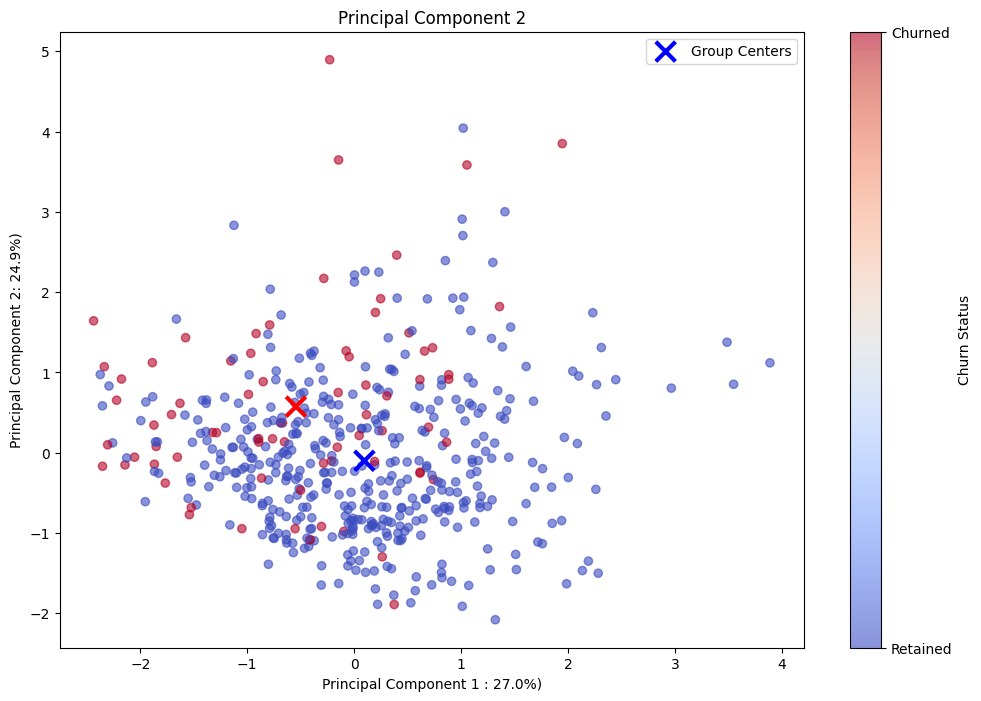

In [121]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=data_streaming['churn'], cmap='coolwarm', alpha=0.6
)
plt.xlabel(f'Principal Component 1 : {pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2: {pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('Principal Component 2')
cbar = plt.colorbar(scatter, label='Churn Status')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Retained', 'Churned'])

# 이탈/유지 고객 중심점 표시
churn_centers = data_streaming.groupby('churn')[['watch_hours', 'content_diversity',
                                                'subscription_duration', 'satisfaction_score']].mean()
churn_centers_scaled = scaler.transform(churn_centers)
churn_centers_pca = pca.transform(churn_centers_scaled)
plt.scatter(churn_centers_pca[:, 0], churn_centers_pca[:, 1],
           c=['blue', 'red'], s=200, marker='x', linewidths=3, label='Group Centers')
plt.legend()
plt.show()


In [128]:
# 3. 고객 세분화

kmeans = KMeans(n_clusters=3, random_state=789)
data_streaming['cluster'] = kmeans.fit_predict(X_scaled)
cluster_summary = data_streaming.groupby('cluster')[features + ['churn']].mean()

print("📊 고객 세그먼트별 특징 분석")
print(cluster_summary.round(2))

# 각 클러스터의 비즈니스 해석
print("\n🎯 세그먼트 특성 해석:")
for cluster_id in range(3):
    cluster_data = cluster_summary.loc[cluster_id]
    churn_rate = cluster_data['churn'] * 100

    print(f"\n[세그먼트 {cluster_id}] - 이탈률: {churn_rate:.1f}%")
    print(f"  • 월 시청시간: {cluster_data['watch_hours']:.1f}시간")
    print(f"  • 콘텐츠 다양성: {cluster_data['content_diversity']:.1f}/10")
    print(f"  • 구독기간: {cluster_data['subscription_duration']:.1f}개월")
    print(f"  • 만족도: {cluster_data['satisfaction_score']:.1f}/10")

    # 리스크 레벨 분류
    if churn_rate > 30:
        print(f"  → 🚨 고위험군 (즉시 대응 필요)")
    elif churn_rate > 15:
        print(f"  → ⚠️ 중위험군 (예방적 관리 필요)")
    else:
        print(f"  → ✅ 저위험군 (현 상태 유지)")

# 세그먼트 크기
segment_sizes = data_streaming['cluster'].value_counts().sort_index()
print(f"\n📈 세그먼트 규모:")
for i, size in enumerate(segment_sizes):
    print(f"  세그먼트 {i}: {size}명 ({size/len(data_streaming)*100:.1f}%)")

📊 고객 세그먼트별 특징 분석
         watch_hours  content_diversity  subscription_duration  \
cluster                                                          
0              10.62               7.69                   7.81   
1              13.92               5.56                  31.43   
2              10.95               3.10                   7.12   

         satisfaction_score  churn  
cluster                             
0                      7.32   0.09  
1                      7.15   0.25  
2                      6.67   0.16  

🎯 세그먼트 특성 해석:

[세그먼트 0] - 이탈률: 9.2%
  • 월 시청시간: 10.6시간
  • 콘텐츠 다양성: 7.7/10
  • 구독기간: 7.8개월
  • 만족도: 7.3/10
  → ✅ 저위험군 (현 상태 유지)

[세그먼트 1] - 이탈률: 25.3%
  • 월 시청시간: 13.9시간
  • 콘텐츠 다양성: 5.6/10
  • 구독기간: 31.4개월
  • 만족도: 7.2/10
  → ⚠️ 중위험군 (예방적 관리 필요)

[세그먼트 2] - 이탈률: 16.0%
  • 월 시청시간: 10.9시간
  • 콘텐츠 다양성: 3.1/10
  • 구독기간: 7.1개월
  • 만족도: 6.7/10
  → ⚠️ 중위험군 (예방적 관리 필요)

📈 세그먼트 규모:
  세그먼트 0: 207명 (41.4%)
  세그먼트 1: 99명 (19.8%)
  세그먼트 2: 194명 (38.8%)


In [137]:
segment_sizes

,count
cluster,
0,207
1,99
2,194


In [172]:
# 4. 이탈 예측 모델
X_logistic = X_scaled
y_logistic = data_streaming['churn']
logistic_model = LogisticRegression(random_state=789)

# 모델 학습 및 예측
logistic_model = LogisticRegression(random_state=789)
logistic_model.fit(X_logistic, y_logistic)

y_pred_proba = logistic_model.predict_proba(X_logistic)[:, 1]
y_pred = logistic_model.predict(X_logistic)

accuracy = (y_pred == y_logistic).mean()
print(f"이탈 예측 모델 정확도: {accuracy:.3f} ({accuracy*100:.1f}%)")

# 변수별 중요도 분석
feature_importance = pd.DataFrame({
    '변수': features,
    '계수': logistic_model.coef_[0],
    '중요도': np.abs(logistic_model.coef_[0])
}).sort_values('중요도', ascending=False)

print("\n📊 이탈 예측 주요 변수")
print(feature_importance.round(3))

# 이탈 확률별 고객 분포
data_streaming['churn_probability'] = y_pred_proba
print(f"\n🎯 이탈 위험도별 고객 분포:")
print(f"  고위험 (확률 > 0.7): {(y_pred_proba > 0.7).sum()}명")
print(f"  중위험 (0.3 < 확률 ≤ 0.7): {((y_pred_proba > 0.3) & (y_pred_proba <= 0.7)).sum()}명")
print(f"  저위험 (확률 ≤ 0.3): {(y_pred_proba <= 0.3).sum()}명")


이탈 예측 모델 정확도: 0.870 (87.0%)

📊 이탈 예측 주요 변수
                      변수     계수    중요도
3     satisfaction_score -1.366  1.366
2  subscription_duration  0.599  0.599
0            watch_hours -0.441  0.441
1      content_diversity  0.028  0.028

🎯 이탈 위험도별 고객 분포:
  고위험 (확률 > 0.7): 11명
  중위험 (0.3 < 확률 ≤ 0.7): 69명
  저위험 (확률 ≤ 0.3): 420명


In [185]:
# 5. 모델 성능 분석
cm = confusion_matrix(y_logistic, y_pred)
tn, fp, fn, tp = cm.ravel()

print("📋 이탈 예측 모델 성능 분석")
print(f"정확히 예측한 유지 고객 (True Negative): {tn}명")
print(f"이탈로 잘못 예측한 유지 고객 (False Positive): {fp}명")
print(f"유지로 잘못 예측한 이탈 고객 (False Negative): {fn}명")
print(f"정확히 예측한 이탈 고객 (True Positive): {tp}명")

# 비즈니스 메트릭 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n🎯 비즈니스 성과 지표:")
print(f"정밀도 (Precision): {precision:.3f} - 이탈 예측 중 실제 이탈 비율")
print(f"재현율 (Recall): {recall:.3f} - 실제 이탈 고객 중 예측 성공 비율")
print(f"F1-Score: {f1_score:.3f} - 종합 성능 지표")

# 비즈니스 손실 분석
retention_cost_per_customer = 50000  # 고객 유지 비용 (쿠폰, 할인 등)
lost_revenue_per_churn = 200000     # 이탈 고객당 매출 손실

unnecessary_retention_cost = fp * retention_cost_per_customer # 이탈 안 할 고객에게 쓴 비용
missed_revenue_loss = fn * lost_revenue_per_churn # 이탈할 고객을 놓쳐서 추가된 비용

print(f"\n💰 예상 비용 분석:")
print(f"불필요한 유지 비용 (False Positive): {unnecessary_retention_cost:,}원")
print(f"놓친 이탈로 인한 손실 (False Negative): {missed_revenue_loss:,}원")
print(f"총 예상 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")

# 매출 분석
revenue_gain_from_retention = tp * lost_revenue_per_churn

print(f"\n💰 예상 회복 매출:")
print(f"고객 이탈 방지로 회복한 매출(True Positive): {revenue_gain_from_retention:,}원")

# ROI 분석
roi = (revenue_gain_from_retention / (unnecessary_retention_cost + missed_revenue_loss) - 1) * 100
print("\n💡ROI 분석")

if roi <0:
  print(f"현재 ROI:{roi:.2f}")
  print("⚠️현재 예측 정확도 기준으로는 불필요한 유지 비용이 너무 큰 상황, 예측 모델 개선 필요(비용 민감도 반영한 Threshold 조정 등)")
else:
  print(f"현재 ROI:{roi:.2f}")


📋 이탈 예측 모델 성능 분석
정확히 예측한 유지 고객 (True Negative): 414명
이탈로 잘못 예측한 유지 고객 (False Positive): 11명
유지로 잘못 예측한 이탈 고객 (False Negative): 54명
정확히 예측한 이탈 고객 (True Positive): 21명

🎯 비즈니스 성과 지표:
정밀도 (Precision): 0.656 - 이탈 예측 중 실제 이탈 비율
재현율 (Recall): 0.280 - 실제 이탈 고객 중 예측 성공 비율
F1-Score: 0.393 - 종합 성능 지표

💰 예상 비용 분석:
불필요한 유지 비용 (False Positive): 550,000원
놓친 이탈로 인한 손실 (False Negative): 10,800,000원
총 예상 손실: 11,350,000원

💰 예상 회복 매출:
고객 이탈 방지로 회복한 매출(True Positive): 4,200,000원

💡ROI 분석
현재 ROI:-63.00
⚠️현재 예측 정확도 기준으로는 불필요한 유지 비용이 너무 큰 상황, 예측 모델 개선 필요(Threshold 조정 등)


📊 AUC 성능 평가: 0.851 → 우수함 (상용화 가능 수준)


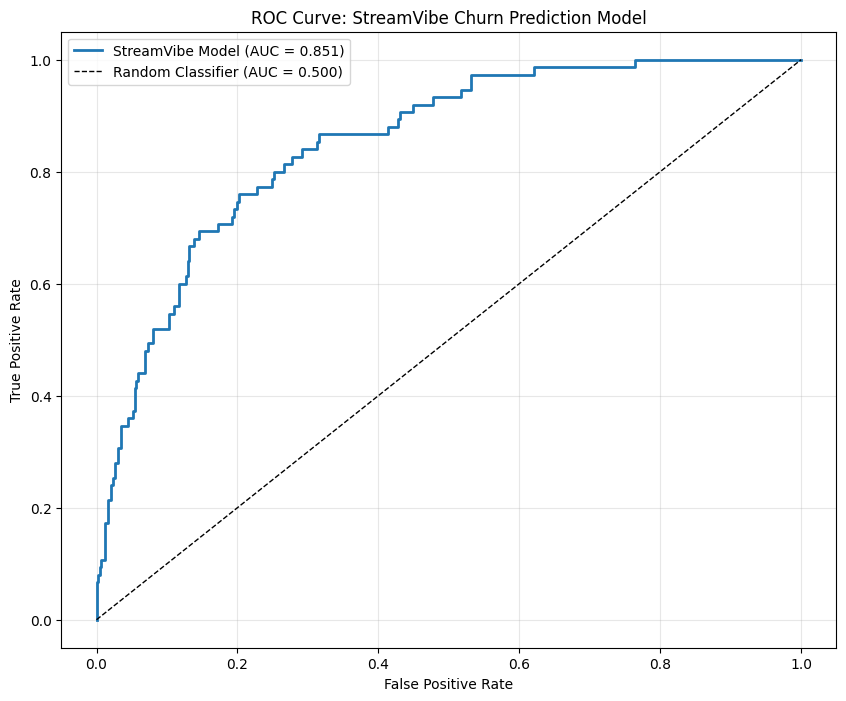

🎯 최적 예측 임계값: 0.165
   이 임계값에서 민감도: 0.760, 특이도: 0.798


In [136]:
fpr, tpr, thresholds = roc_curve(y_logistic, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'StreamVibe Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: StreamVibe Churn Prediction Model')
plt.legend()
plt.grid(True, alpha=0.3)

# AUC 성능 해석
if roc_auc > 0.9:
    performance_level = "탁월함 (업계 최고 수준)"
elif roc_auc > 0.8:
    performance_level = "우수함 (상용화 가능 수준)"
elif roc_auc > 0.7:
    performance_level = "양호함 (개선 여지 있음)"
else:
    performance_level = "부족함 (추가 개선 필요)"

print(f"📊 AUC 성능 평가: {roc_auc:.3f} → {performance_level}")
plt.show()

# 최적 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"🎯 최적 예측 임계값: {optimal_threshold:.3f}")
print(f"   이 임계값에서 민감도: {tpr[optimal_idx]:.3f}, 특이도: {1-fpr[optimal_idx]:.3f}")


In [165]:
high_risk_cluster = cluster_summary.sort_values(by='churn', ascending=False).iloc[0]
second_high_risk_cluster = cluster_summary.sort_values(by='churn', ascending=False).iloc[1]
high_risk_cluster_id = cluster_summary.sort_values(by='churn', ascending=False).index[0]
second_high_risk_cluster_id = cluster_summary.sort_values(by='churn', ascending=False).index[1]

In [174]:
feature_importance

,변수,계수,중요도
3,satisfaction_score,-1.366445,1.366445
2,subscription_duration,0.599442,0.599442
0,watch_hours,-0.440839,0.440839
1,content_diversity,0.027977,0.027977


In [198]:
# 이탈률과 고객 수 기반 계산
current_churn_rate = data_streaming['churn'].mean()
total_customers = len(data_streaming)
current_churned_customers = int(current_churn_rate * total_customers)

# 30% 이탈 감소 가정
reduced_churn_count = int(current_churned_customers * 0.3)
lost_revenue_per_customer = 200_000
recovered_revenue = reduced_churn_count * lost_revenue_per_customer

# 총 유지 비용
total_retention_cost = reduced_churn_count * retention_cost_per_customer
roi = (recovered_revenue - total_retention_cost) / total_retention_cost * 100

# 출력
print(f"• 현재 전체 이탈 고객 수: {current_churned_customers}명")
print(f"• 30% 감소 시 유지 고객 수: {reduced_churn_count}명")
print(f"• 예상 회복 매출: {recovered_revenue:,}원")
print(f"• 예상 유지 비용: {total_retention_cost:,}원")
print(f"• ROI (투자 대비 수익률): {roi:.1f}%")

✅ 현재 전체 이탈 고객 수: 75명
🎯 30% 감소 시 유지 고객 수: 22명
💰 예상 회복 매출: 4,400,000원
• 예상 유지 비용: 1,100,000원
• ROI (투자 대비 수익률): 300.0%


In [202]:
print("📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략")
print("="*55)
print("🚨 현재 상황")
print(f"• 전체 이탈률: {churn_rate:.2f}%(스트리밍 업계 평균 이탈률: 5~15%)")
print(f"• 고객 세그먼트 수: {len(segment_sizes)}개")
print(f"• 이탈 예측 모델 AUC: {roc_auc:.2f}")
print(f"• 모델 정확도: {accuracy*100:.1f}%")

print("\n🎯 핵심 발견사항")
print(f"1. 중위험 세그먼트 특성")
print(f"  세그먼트 {high_risk_cluster_id}:이탈률 {high_risk_cluster['churn']*100:.1f}%")
print(f"   • 월 시청시간: {high_risk_cluster['watch_hours']:.1f}시간")
print(f"   • 콘텐츠 다양성: {high_risk_cluster['content_diversity']:.1f}/10")
print(f"   • 구독기간: {high_risk_cluster['subscription_duration']:.1f}개월")
print(f"   • 만족도: {high_risk_cluster['satisfaction_score']:.1f}/10")
print(f"  \n세그먼트 {second_high_risk_cluster_id}:이탈률 {second_high_risk_cluster['churn']*100:.1f}%")
print(f"   • 월 시청시간: {second_high_risk_cluster['watch_hours']:.1f}시간")
print(f"   • 콘텐츠 다양성: {second_high_risk_cluster['content_diversity']:.1f}/10")
print(f"   • 구독기간: {second_high_risk_cluster['subscription_duration']:.1f}개월")
print(f"   • 만족도: {second_high_risk_cluster['satisfaction_score']:.1f}/10")


print(f"\n2. 이탈 주요 예측 변수: {feature_importance['변수'][3]}({feature_importance['중요도'][3]:.2f}),{feature_importance['변수'][2]}({feature_importance['중요도'][2]:.2f})")
print(f"3. 예측 가능한 이탈 고객: {(y_pred_proba > 0.7).sum()}명 ({((y_pred_proba > 0.7).sum())/y_pred_proba.sum()*100:.1f}%)")

print("\n💡 즉시 실행 가능한 대응 전략")
print("1. 선제적 고객 유지:")
print("   • 이탈 예측 확률이 높은 고객(확률 > 0.7)에게 맞춤형 할인, 시청 리마인더 제공")
print("   • 이탈 가능성이 높은 세그먼트 중심으로 집중 관리")

print("2. 세그먼트별 맞춤 전략:")
print("   • 세그먼트 1: 만족도는 높지만 구독기간이 길어 이탈 위험 존재 →")
print("     → 장기 이용자 대상 로열티 혜택(예: 무료 영화 쿠폰, 한정 콘텐츠 개방) 제공")
print("   • 세그먼트 2: 만족도가 낮고 이탈률 높음 →")
print("     → 개인 취향 기반 큐레이션 패키지 도입, 만족도 하락 원인 심층 분석 필요")

print("3. 콘텐츠 전략 개선:")
print("   • 시청 시간이 높으면 이탈률이 낮지만 콘텐츠 다양성은 이탈률에 크게 영향을 주지 않음")
print("   → 개인화 콘텐츠 추천 알고리즘 개선이 효과적")

print("\n📈 예상 효과")
print(f"• 이탈률 감소 목표: 현재 대비 30% 감소 (16% → {16*0.7}%)")
print(f"• 현재 전체 이탈 고객 수: {current_churned_customers}명")
print(f"• 30% 감소 시 유지 고객 수: {reduced_churn_count}명")
print(f"• 예상 회복 매출: {recovered_revenue:,}원")
print(f"• 예상 유지 비용: {total_retention_cost:,}원")
print(f"• ROI (투자 대비 수익률): {roi:.1f}%")

print("\n⏰ 실행 일정 (향후 3개월)")
print("• 1개월차: 고위험군 식별 및 타겟 마케팅 시작")
print("• 2개월차: 콘텐츠 큐레이션 개선, 혜택 및 쿠폰 지급, 이메일/문자 푸쉬 등 리텐션 캠페인")
print("• 3개월차: 초기 성과 측정 및 전략 조정")

print("\n🔧 필요 리소스")
print("• 데이터팀: 예측 모델 지속 모니터링")
print("• 마케팅팀: 타겟 리텐션 캠페인 집행")
print("• 개발팀: 맞춤형 콘텐츠 추천 알고리즘 개선")

print("\n⚠️ 주의사항")
print("• 현재 예측 모델의 AUC는 0.88로 매우 높은 편이지만, 실제 False Positive 비율이 존재해 무의미한 유지 비용 발생 가능성 있음")
print(f"  → 불필요한 유지 비용: {unnecessary_retention_cost:,}원")
print(f"  → 놓친 이탈로 인한 매출 손실: {missed_revenue_loss:,}원")
print(f"  → 총 손실: {unnecessary_retention_cost + missed_revenue_loss:,}원")
print(f"• 고객 이탈 방지로 회복한 매출(True Positive): {revenue_gain_from_retention:,}원")
print(f"• 현재 ROI:{roi:.0f}%로 단순한 모델 성능이 곧바로 비용 효율로 이어지지 않음")
print("→ 따라서 전략 실행 전, 모델 threshold 최적화, 고정비용 구조 재검토, 유지 전략 타겟팅 정밀화 필요")


📋 경영진 보고서: StreamVibe 고객 이탈 방지 전략
🚨 현재 상황
• 전체 이탈률: 15.98%(스트리밍 업계 평균 이탈률: 5~15%)
• 고객 세그먼트 수: 3개
• 이탈 예측 모델 AUC: 0.85
• 모델 정확도: 87.0%

🎯 핵심 발견사항
1. 중위험 세그먼트 특성
  세그먼트 1:이탈률 25.3%
   • 월 시청시간: 13.9시간
   • 콘텐츠 다양성: 5.6/10
   • 구독기간: 31.4개월
   • 만족도: 7.2/10
  
세그먼트 2:이탈률 16.0%
   • 월 시청시간: 10.9시간
   • 콘텐츠 다양성: 3.1/10
   • 구독기간: 7.1개월
   • 만족도: 6.7/10

2. 이탈 주요 예측 변수: satisfaction_score(1.37),subscription_duration(0.60)
3. 예측 가능한 이탈 고객: 11명 (14.7%)

💡 즉시 실행 가능한 대응 전략
1. 선제적 고객 유지:
   • 이탈 예측 확률이 높은 고객(확률 > 0.7)에게 맞춤형 할인, 시청 리마인더 제공
   • 이탈 가능성이 높은 세그먼트 중심으로 집중 관리
2. 세그먼트별 맞춤 전략:
   • 세그먼트 1: 만족도는 높지만 구독기간이 길어 이탈 위험 존재 →
     → 장기 이용자 대상 로열티 혜택(예: 무료 영화 쿠폰, 한정 콘텐츠 개방) 제공
   • 세그먼트 2: 만족도가 낮고 이탈률 높음 →
     → 개인 취향 기반 큐레이션 패키지 도입, 만족도 하락 원인 심층 분석 필요
3. 콘텐츠 전략 개선:
   • 시청 시간이 높으면 이탈률이 낮지만 콘텐츠 다양성은 이탈률에 크게 영향을 주지 않음
   → 개인화 콘텐츠 추천 알고리즘 개선이 효과적

📈 예상 효과
• 이탈률 감소 목표: 현재 대비 30% 감소 (16% → 11.2%)
• 현재 전체 이탈 고객 수: 75명
• 30% 감소 시 유지 고객 수: 22명
• 예상 회복 매출: 4,400,000원
• 예상 유지 비용: 1,100,000원
• ROI (투자 대